In [1]:
import pandas as pd
import os
import torch
from PIL import Image
from transformers import CLIPModel
from transformers import CLIPProcessor
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [3]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

#whereever you loaded your vit_h file
sam_checkpoint ="/Users/meagankenney/IMA Bootcamp/Ebay/sam_vit_h_4b8939.pth"
model_type = "vit_h"


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
#sam.to(device=device)

predictor = SamPredictor(sam)

In [68]:
#put a path to your picture in parentheses below
image = cv2.imread('/Users/meagankenney/IMA Bootcamp/Ebay/modelWithShirt.jpeg')
#image = cv2.imread('/Users/meagankenney/IMA Bootcamp/Ebay/testpic2copy 2.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

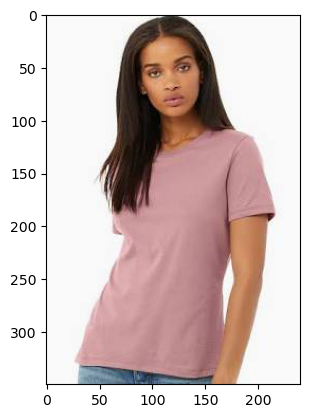

In [30]:
plt.imshow(image)

In [6]:
predictor.set_image(image)

In [31]:
#pick the two numbers in brackets below to indicate on what you want segment anything to create the mask
input_point = np.array([[125, 200]])
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [32]:
int_mask = masks.astype(int)

In [33]:
input_point

array([[125, 200]])

In [34]:
# Extracting pixel map:
# Extracting the width and height 
# of the image:
width = image.shape[0]
height = image.shape[1]
for i in range(width):
    for j in range(height):
        # getting the current RGB value of pixel (i,j).
        if int_mask[0][i][j]==0:
            image[i][j]=(255,255,255)
        
        

In [41]:
# Extracting pixel map:
# Extracting the width and height 
# of the image:
colList=[]
width = image.shape[0]
height = image.shape[1]
for i in range(width):
    for j in range(height):
        # getting the current RGB value of pixel (i,j).
        if int_mask[0][i][j]==1:
            colList.append(image[i][j])
        
        

In [57]:
def AvgColor(image):  
    colList=[]
    width = image.shape[0]
    height = image.shape[1]
    for i in range(width):
        for j in range(height):
            # getting the current RGB value of pixel (i,j).
            if int_mask[0][i][j]==1:
                colList.append(image[i][j])
    L=len(colList)
    m1=0
    m2=0
    m3=0
    for i in colList:
        m1+=i[0]
        m2+=i[1]
        m3+=i[2]
    return [(m1/L, m2/L, m3/L)]

In [62]:
AvgColor(image)

[(0.0, 84.55293053972247, 189.51039742128228)]

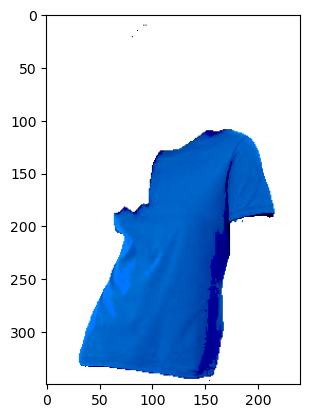

In [63]:
plt.imshow(image)

In [64]:
def colorChange3(col2, pic):
    #Get dimensions of image
    width = pic.shape[0]
    height = pic.shape[1]
    
    #Fix a base color
    startCol = AvgColor(pic)
    
    #How different is this base color from target color?
    dif1 = startCol[0][0] - col2[0]
    dif2 = startCol[0][1] - col2[1]
    dif3 = startCol[0][2] - col2[2]
    
    #Go through all pixels in the picture
    for i in range(width):
        for j in range(height):
            # Is this picture on the segment we're recoloring?
            if int_mask[0][i][j]==1:
                #Change R value
                if 0<= pic[i][j][0]-dif1<=255:
                    pic[i][j][0] -=dif1
                if pic[i][j][0]-dif1< 0:
                    pic[i][j][0]=0
                if pic[i][j][0]-dif1> 255:
                    pic[i][j][0]=255
                #Change G Value
                if 0<= pic[i][j][1]-dif2<=255:
                    pic[i][j][1] -=dif2
                if pic[i][j][1]-dif2< 0:
                    pic[i][j][1]=0
                if pic[i][j][1]-dif2> 255:
                    pic[i][j][1]=255
                #Change B Value    
                if 0<= pic[i][j][2]+dif3<=255:
                    pic[i][j][2] -=dif3
                if pic[i][j][2]-dif3< 0:
                    pic[i][j][2]=0
                if pic[i][j][2]-dif3> 255:
                    pic[i][j][2]=255
    

In [65]:
image[150][150]

array([  0, 100, 200], dtype=uint8)

In [69]:
colorChange3((20, 100, 200), image)

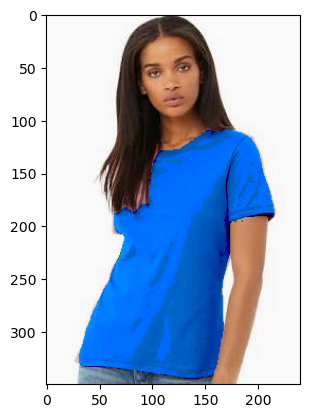

In [70]:
plt.imshow(image)